In [3]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
from collections import Counter
import nltk
from numpy import trapz
from scipy.signal import find_peaks
import re

stop_words_nltk = nltk.corpus.stopwords.words('portuguese')
snowball = nltk.stem.snowball.SnowballStemmer('portuguese')
right=[ 'PSD',  'CDS-PP', 'CH','IL','CDS']
left=[ 'PS', 'BE', 'PCP', 'PAN', 'PEV','L']

In [4]:
# FUNCTIONS
def clean_tweets(text):

        emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                "]+", flags=re.UNICODE)
        text=emoji_pattern.sub(r'', text)

        text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE) 
        
        

        return text

def remove_punctuation(col_name, df):
    df[col_name]=df[col_name].str.replace('[^\w\s]', '')
    print('Punctuation removed')
    return df

def remove_special_char(col_name, df, char1,char2):
    df[col_name]=df[col_name].str.replace(char1,char2)
    print('Character '+char1 + 'replaced by '+ char2)
    return df

def aux_remove_accents(a):
    import unidecode
    return unidecode.unidecode(a)

def remove_accents(col_name, df ):
    df[col_name] = df[col_name].apply(aux_remove_accents)
    print('Accents removed')
    return df

def normlizeTokens(tokenLst, stopwordLst = None, stemmer = None):
    #We can use a generator here as we just need to iterate over it

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)
         
    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)
    #We will return a list with the stopwords removed
    return list(workingIter)

def create_tokenized_dataset(df_input, text_col):
    # 1 create token column: tokens
    df_input['tokens']=df_input[text_col].apply(lambda x: nltk.word_tokenize(x))
    # 2 create token without stopwords and stemmer: tokens_stemer_stop. 16min
    df_input['tokens_stemer_stop'] = df_input['tokens'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = snowball))
    
    # 3 extract very frequent or rare words: token_cleaned
    flat_tokens=[item for sublist in df_input['tokens_stemer_stop'] for item in sublist]
    aux_c=Counter(flat_tokens)
        
    extrat_common=['par', 'nao', 'sr', 'deput', 'govern', 'muit', 'pel', 'president','tod','tamb','srs','sras','pod','part','psd','sao','aplaus','ja','porqu','faz','ha','diz','quer','pais','sobr','bem','nest']
    extract_rare=[x[0] for x in aux_c.most_common()[-30:]]

    df_input['tokens_cleaned'] = df_input['tokens_stemer_stop'].apply(lambda x : [i for i in x if not i in extrat_common])
    df_input['tokens_cleaned'] = df_input['tokens_cleaned'].apply(lambda x : [i for i in x if not i in extract_rare])
    #df_input.to_pickle('dftok.pkl')  
    return df_input

def generate_N_grams(text,ngram=1):
  words=[word for word in text]  
  temp=zip(*[words[i:] for i in range(0,ngram)])
  ans=[' '.join(ngram) for ngram in temp]
  return ans

def create_grams(df_frame, n):
    grams_d={1: 'uni_grams', 2: 'bi_grams', 3: 'tri_grams'}
    df_frame[grams_d[n]] = df_frame['tokens_cleaned'].apply(lambda x: generate_N_grams(x,n))
    return df_frame 

#political polarization functions




def create_frequency_table_grams(n_gram=1, indf=None, right_parties=right, left_parties=left):
    grams_d={1: 'uni_grams', 2: 'bi_grams', 3: 'tri_grams'}
   

    r_grams=[item for sublist in indf[indf.party.isin(right)][grams_d[n_gram]] for item in sublist]
    l_grams=[item for sublist in indf[indf.party.isin(left)][grams_d[n_gram]] for item in sublist]

    total_counter = Counter([item for sublist in indf[grams_d[n_gram]] for item in sublist])
    right_counter = Counter(r_grams)
    left_counter = Counter(l_grams)

    df_all = pd.DataFrame.from_dict(total_counter, orient='index').reset_index()
    df_all.columns=['phrase','count']
    df_all['count_right']=[right_counter[x] for x in df_all.phrase]
    df_all['count_left']=[left_counter[x] for x in df_all.phrase]


    df_all['count_left_total']=sum(left_counter.values())
    df_all['count_right_total']=sum(right_counter.values())
    # frequency of every words except the given one (by row)
    #Jensen et al. (2012),p.10 
    #f-pck is the frequency of all phrases used in Con­gress c by party k excluding phrase p
    df_all['f_right_minus']=( df_all['count_right_total']-df_all['count_right'])/df_all['count_right_total']
    df_all['f_left_minus']=( df_all['count_left_total']-df_all['count_left'])/df_all['count_left_total']

    df_all['f_right']=df_all['count_right']/df_all['count_right_total']
    df_all['f_right_norm'] = (df_all['f_right'] - df_all['f_right'].min()) / (df_all['f_right'].max() - df_all['f_right'].min())  
    df_all['f_left']=df_all['count_left']/df_all['count_left_total']
    df_all['f_left_norm'] = (df_all['f_left'] - df_all['f_left'].min()) / (df_all['f_left'].max() - df_all['f_left'].min())  

    df_all['f_right_minus_norm']=(df_all['f_right_minus'] - df_all['f_right_minus'].min()) / (df_all['f_right_minus'].max() - df_all['f_right_minus'].min()) 
    df_all['f_left_minus_norm']=(df_all['f_left_minus'] - df_all['f_left_minus'].min()) / (df_all['f_left_minus'].max() - df_all['f_left_minus'].min()) 

    return df_all


def calculate_pearson(df_all):
    aa=df_all['f_right_norm']*df_all['f_left_minus_norm'] 
    bb=df_all['f_left_norm']*df_all['f_right_minus_norm']
    cc=aa-bb
    dd=cc*cc
    d11=df_all['f_right_norm']+df_all['f_left_norm']
    d22=df_all['f_right_norm']+df_all['f_right_minus_norm']
    d33=df_all['f_left_norm']+df_all['f_left_minus_norm']
    d44=df_all['f_right_minus_norm']+df_all['f_left_minus_norm']
    denom=d11*d22*d33*d44
    pp=dd/denom
    return pp

def create_phrase_partisanship(df):
    aa=df['f_right_norm']+df['f_left_norm']
    df['rho']=df['f_right_norm']/aa
    
    df['gram_partisanship']= 0.5 * df['f_right_norm']*df['rho']+0.5 *df['f_right_norm']*(1-df['rho'])
    
    return df

def create_polarization_correlation(df):
    
    aa=df['f_left_norm']*-1
    bb= df['f_right_norm']*1
    df['beta_polarization']=aa+bb

    return df

def partisanship_by_speach(df_in,partisan_dict, new_column='partisanship', ngrams_col='tri_grams'):
    df_in[new_column] = [np.empty(0,dtype=float)]*len(df_in)
    df_in[new_column] =df_in[new_column].astype(object)
    out_res=[]
    for n,row in enumerate(df_in[ngrams_col]):
    
        res=[]
        for x in row:
            
            if x in partisan_dict:
                res.append( partisan_dict[x])
            
            else:
                res.append( 0)
        out_res.append(res)
    df_in[new_column]=out_res
    return df_in

def create_200r(df_mainf):
    indexes_no_applause=[n for n,x in enumerate(df_mainf.phrase) if 'aplausos' not in x]
    df_mainf=df_mainf.iloc[indexes_no_applause]

    tri_final = df_mainf[0:200].append(df_mainf[-200:], ignore_index=True)
    return tri_final


def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return  idx


In [5]:
#read data
tweets_df= pd.read_pickle('raw_tweets.pkl')  
replies_df= pd.read_pickle('raw_replies.pkl')  
df_twitter=pd.read_csv('twitter_deputies.csv')

In [6]:
#ADD party 
df_twitter = df_twitter.rename(columns={'twitter': 'user_name'})
df_twitter['user_name']=df_twitter['user_name'].str.lower()
tweets_df['user_name']=tweets_df['user_name'].str.lower()
df_ptweets=tweets_df.merge(df_twitter[['party', 'user_name']], on='user_name', how='left')

In [7]:
df_ptweets['text_clean']=df_ptweets['text'].str.lower()
df_ptweets['text_clean']=df_ptweets['text_clean'].apply(lambda x : clean_tweets(x))
df_ptweets['text_clean']=df_ptweets['text_clean'].apply(lambda x : re.sub('RT @\w+: ','  ',x))
df_ptweets= remove_special_char('text_clean', df_ptweets, 'ç','c') #dialogsDF['clean_speaker'].str.replace('ç','c')
df_ptweets= remove_punctuation('text_clean', df_ptweets) #dialogsDF['clean_speaker'].str.replace('[^\w\s]', '')
df_ptweets= remove_accents('text_clean', df_ptweets)

Character çreplaced by c


C:\Users\trind\AppData\Local\Temp\ipykernel_10520\2944213905.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
  df[col_name]=df[col_name].str.replace('[^\w\s]', '')


Punctuation removed
Accents removed


In [8]:
df_twitter_tok=create_tokenized_dataset(df_ptweets,'text_clean')

In [9]:
df_twitter_tok.head(2)

,user_name,text,year,tweet_id,url,party,text_clean,tokens,tokens_stemer_stop,tokens_cleaned
0,alexandre_poco,✍🏻 Convido à leitura do artigo de opinião que ...,2021,1475489298027843592,https://twitter.com/Alexandre_Poco/status/1475...,PSD,convido a leitura do artigo de opiniao que es...,"[convido, a, leitura, do, artigo, de, opiniao,...","[conv, leitur, artig, opinia, escrev, novosema...","[conv, leitur, artig, opinia, escrev, novosema..."
1,alexandre_poco,🗣 No congresso do meu partido a defender um no...,2021,1473000761621508096,https://twitter.com/Alexandre_Poco/status/1473...,PSD,no congresso do meu partido a defender um nov...,"[no, congresso, do, meu, partido, a, defender,...","[congress, part, defend, nov, caminh, par, nos...","[congress, defend, nov, caminh, noss, jsd, ppd..."


In [10]:
# 1 Create n-grams
#df_tok=create_grams(df_tok, 2)
df_twitter_gram=create_grams(df_twitter_tok, 3)

In [11]:
# 2 create frequency table
df_tweets_freq=create_frequency_table_grams(n_gram=3, indf=df_twitter_gram, right_parties=right, left_parties=left)
# 3 Filter pearson >0
df_tweets_freq['pearson_quad']=calculate_pearson(df_tweets_freq)
trigrams_tweet_table=df_tweets_freq[df_tweets_freq.pearson_quad>0]
#  4 Add  partisanship by word
trigrams_tweet_table=create_phrase_partisanship(trigrams_tweet_table)
trigrams_tweet_table=create_polarization_correlation(trigrams_tweet_table)
trigrams_tweet_table=trigrams_tweet_table.sort_values(by='gram_partisanship',ascending=False)

In [12]:
# 5 Dictionary of trigrams and partisanship
partisan_dict=dict(zip(trigrams_tweet_table.phrase,trigrams_tweet_table.gram_partisanship))

In [13]:
# 6 Partisanship by speach
df_twitter_gram=partisanship_by_speach(df_in=df_twitter_gram, new_column='partisanship', ngrams_col='tri_grams',partisan_dict=partisan_dict)
df_twitter_gram['avg_partisanship']=df_twitter_gram.partisanship.apply(lambda x: sum(x))

In [14]:
df_twitter_gram.head(2)

,user_name,text,year,tweet_id,url,party,text_clean,tokens,tokens_stemer_stop,tokens_cleaned,tri_grams,partisanship,avg_partisanship
0,alexandre_poco,✍🏻 Convido à leitura do artigo de opinião que ...,2021,1475489298027843592,https://twitter.com/Alexandre_Poco/status/1475...,PSD,convido a leitura do artigo de opiniao que es...,"[convido, a, leitura, do, artigo, de, opiniao,...","[conv, leitur, artig, opinia, escrev, novosema...","[conv, leitur, artig, opinia, escrev, novosema...","[conv leitur artig, leitur artig opinia, artig...","[0.001436781609195402, 0.0014367816091954023, ...",0.010057
1,alexandre_poco,🗣 No congresso do meu partido a defender um no...,2021,1473000761621508096,https://twitter.com/Alexandre_Poco/status/1473...,PSD,no congresso do meu partido a defender um nov...,"[no, congresso, do, meu, partido, a, defender,...","[congress, part, defend, nov, caminh, par, nos...","[congress, defend, nov, caminh, noss, jsd, ppd...","[congress defend nov, defend nov caminh, nov c...","[0.001436781609195402, 0.001436781609195402, 0...",0.010057


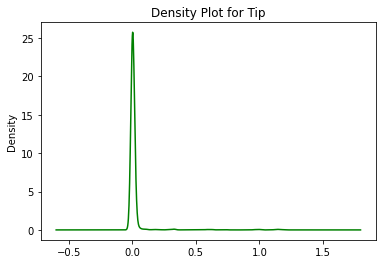

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
df_twitter_gram['avg_partisanship'].plot.density(color='green')
plt.title('Density Plot for Tip')
plt.show()

In [16]:
df_twitter_gram.sort_values("avg_partisanship", axis =0, ascending = False,inplace = True)
tri_final = df_twitter_gram[0:500].append(df_twitter_gram[-500:], ignore_index=True)

C:\Users\trind\AppData\Local\Temp\ipykernel_10520\1178378920.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tri_final = df_twitter_gram[0:500].append(df_twitter_gram[-500:], ignore_index=True)


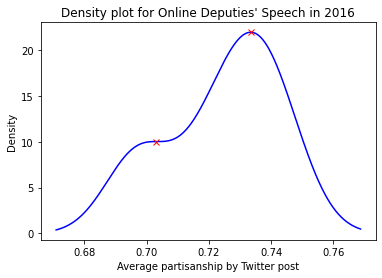

1o 0.3413505058777847 0.5640010293096163
no data for 2017


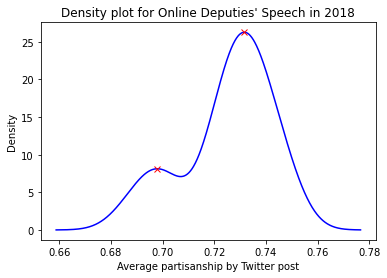

1o 0.24514766193697618 0.6771915933975217


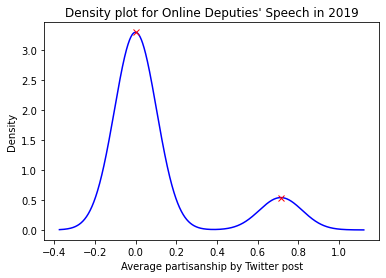

1o 0.8567975604135415 0.14300065482522648


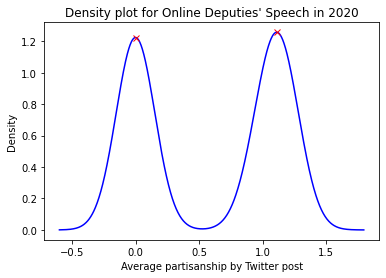

1o 0.4672967351809527 0.5324988548272165


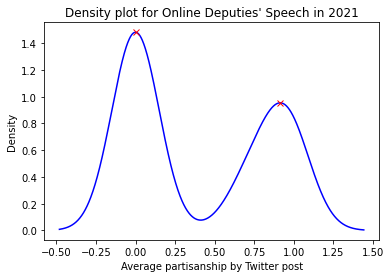

1o 0.5599657607995517 0.43865087720066814


<Figure size 432x288 with 0 Axes>

In [29]:
# 
df_polmetric=pd.DataFrame([])

for YEAR_S in range(2016, 2022):
    try:
        res=[]
        tri_final[tri_final.year==YEAR_S]['avg_partisanship'].plot.density(color='blue')
        plt.title("Density plot for Online Deputies' Speech in "+ str(YEAR_S))
        plt.xlabel('Average partisanship by Twitter post')
        line = plt.gca().get_lines()
        x_data = line[0].get_data()[0]
        y1_data = line[0].get_data()[1]
        peaks, _ = find_peaks(y1_data, height=0)
        plt.plot(x_data[peaks[0]],y1_data[peaks[0]], "x", color='red')
        if len(peaks)>1:
            plt.plot(x_data[peaks[1]],y1_data[peaks[1]], "x", color='red')

        plt.show()
        plt.clf()
        if len(peaks)>1:
            #distance_from_peaks=x_data[peaks[0]]

            first_peak_startX=x_data[0]
            fstartY=find_nearest_idx(x_data, first_peak_startX)
            #print(fstartY,fendY)
            first_peak_endX=x_data[peaks[0]]+((x_data[peaks[1]]-x_data[peaks[0]])/2 )
            fendY=find_nearest_idx(x_data, first_peak_endX)
            area_left = trapz(y1_data[fstartY:fendY], x_data[fstartY:fendY],dx=1)

            second_peak_start=first_peak_endX
            SstartY=find_nearest_idx(x_data, second_peak_start)
            second_peak_end=x_data[peaks[1]]+((x_data[peaks[1]]-x_data[peaks[0]])/2 )
            SendY=find_nearest_idx(x_data, second_peak_end)


            area_right = trapz(y1_data[SstartY:SendY], x_data[SstartY:SendY],dx=1)

            print('1o', area_left,area_right)
        else:
            distance_from_peaks=min(x_data[:peaks[0]])

            first_peak_startX=x_data[0]
            fstartY=find_nearest_idx(x_data, first_peak_startX)

            first_peak_endX=x_data[peaks[0]]+((x_data[peaks[0]]-x_data[0])/2 )
            fendY=find_nearest_idx(x_data, first_peak_endX)
            area_left = trapz(y1_data[fstartY:fendY], x_data[fstartY:fendY],dx=1)

            area_right=0
            print(area_left,area_right)

        res.append(YEAR_S)
        if len(peaks)>1:
            res.append(x_data[peaks[1]]-x_data[peaks[0]]) #partisanship_interval
        else:
            res.append(0)
        res.append(area_left)
        res.append( area_right)
    except:
        print('no data for', YEAR_S)

    new_df = pd.DataFrame([res])
    df_polmetric = pd.concat([df_polmetric, new_df], axis=0, ignore_index=True)
    

In [18]:
df_polmetric.columns='year','partisanship_interval', 'left_probability','right_probability'
df_polmetric

,year,partisanship_interval,left_probability,right_probability
0,2016.0,0.030415,0.341351,0.564001
1,NaN,NaN,NaN,NaN
2,2018.0,0.033729,0.245148,0.677192
3,2019.0,0.713472,0.856798,0.143001
4,2020.0,1.109382,0.467297,0.532499
5,2021.0,0.914061,0.559966,0.438651


In [19]:
tri_final
#add term
tri_final['term'] = np.where(tri_final.year <=2019, '13', '14')

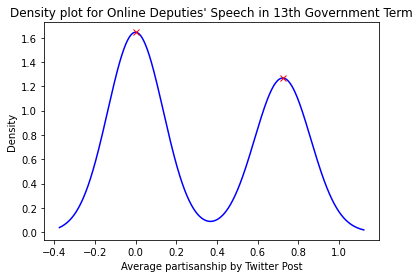

1o 0.5602097089034439 0.43600972752167544


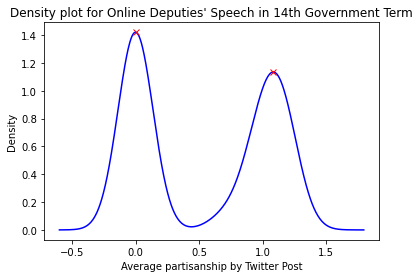

1o 0.49440379364463405 0.5053720750654956


<Figure size 432x288 with 0 Axes>

In [27]:
# 
df_polmetric=pd.DataFrame([])

for YEAR_S in range(13, 15):
    res=[]
    YEAR_S=str(YEAR_S)
    tri_final[tri_final.term==YEAR_S]['avg_partisanship'].plot.density(color='blue')
    plt.title("Density plot for Online Deputies' Speech in "+ str(YEAR_S)+ 'th Government Term')
    plt.xlabel('Average partisanship by Twitter Post')
    line = plt.gca().get_lines()
    x_data = line[0].get_data()[0]
    y1_data = line[0].get_data()[1]
    peaks, _ = find_peaks(y1_data, height=0)
    plt.plot(x_data[peaks[0]],y1_data[peaks[0]], "x", color='red')
    if len(peaks)>1:
        plt.plot(x_data[peaks[1]],y1_data[peaks[1]], "x", color='red')

    plt.show()
    plt.clf()
    if len(peaks)>1:
        #distance_from_peaks=x_data[peaks[0]]

        first_peak_startX=x_data[0]
        fstartY=find_nearest_idx(x_data, first_peak_startX)
        #print(fstartY,fendY)
        first_peak_endX=x_data[peaks[0]]+((x_data[peaks[1]]-x_data[peaks[0]])/2 )
        fendY=find_nearest_idx(x_data, first_peak_endX)
        area_left = trapz(y1_data[fstartY:fendY], x_data[fstartY:fendY],dx=1)

        second_peak_start=first_peak_endX
        SstartY=find_nearest_idx(x_data, second_peak_start)
        second_peak_end=x_data[peaks[1]]+((x_data[peaks[1]]-x_data[peaks[0]])/2 )
        SendY=find_nearest_idx(x_data, second_peak_end)


        area_right = trapz(y1_data[SstartY:SendY], x_data[SstartY:SendY],dx=1)

        print('1o', area_left,area_right)
    else:
        distance_from_peaks=min(x_data[:peaks[0]])

        first_peak_startX=x_data[0]
        fstartY=find_nearest_idx(x_data, first_peak_startX)

        first_peak_endX=x_data[peaks[0]]+((x_data[peaks[0]]-x_data[0])/2 )
        fendY=find_nearest_idx(x_data, first_peak_endX)
        area_left = trapz(y1_data[fstartY:fendY], x_data[fstartY:fendY],dx=1)

        area_right=0
        print(area_left,area_right)

    res.append(YEAR_S)
    if len(peaks)>1:
        res.append(x_data[peaks[1]]-x_data[peaks[0]]) #partisanship_interval
    else:
        res.append(0)
    res.append(area_left)
    res.append( area_right)

    new_df = pd.DataFrame([res])
    df_polmetric = pd.concat([df_polmetric, new_df], axis=0, ignore_index=True)

In [21]:
df_polmetric.columns='term','partisanship_interval', 'left_probability','right_probability'
df_polmetric

,term,partisanship_interval,left_probability,right_probability
0,13,0.722447,0.560210,0.436010
1,14,1.083026,0.494404,0.505372
